In [10]:
import os 
import json 
import pandas as pd 
import polars as pl 
import numpy as np
from tqdm import tqdm 
import time 
from datetime import timedelta

import sys
import os

current_dir = os.getcwd()  # Se in notebook
src_path = os.path.abspath(os.path.join(current_dir, '..', 'src'))

if src_path not in sys.path:
    sys.path.append(src_path)

from pumps_selector import circular_right_shift
from lower_mpc import step_lower_mpc, LMPCDataBuffer
from upper_mpc import step_upper_level, UMPCDataBuffer
from datetime import datetime, timezone


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
#time = pl.read_parquet(os.path.join(data_path_wsl, "sim_data/sim_data_1h_full.par"))
#upper_mpc_data_pan = pl.read_parquet(os.path.join(data_path_wsl, "sim_data/sim_data_1h_full.par"))
#p1= pl.read_parquet("/home/alqua/data/data_vdfs/pump1_power_siso.par").group_by_dynamic(index_column="time", every="1h").agg(pl.col("pump1_power").mean())
#p4= pl.read_parquet("/home/alqua/data/data_vdfs/pump4_power_siso.par").group_by_dynamic(index_column="time", every="1h").agg(pl.col("pump4_power").mean())
#p3= pl.read_parquet("/home/alqua/data/data_vdfs/pump3_power_siso.par").group_by_dynamic(index_column="time", every="1h").agg(pl.col("pump3_power").mean())
#pumps_df = p1.join(p4, on="time").join(p3, on="time")
#baseline_df = (pumps_df.group_by("hours").agg(
#                    pl.col("energy_cons").mean().alias("mean_energy_cons"),
#                    pl.col("energy_cons").std().alias("std_energy_cons")
#                ).sort("hours"))

In [12]:
data_path_wsl = "/home/alqua/data/pump_station_data/"
data = pl.read_parquet('/home/alqua/papers/mbs_flexibility_mpc_rev_v1/mpc/input_data/aggregated_data_for_mpc.par')

In [13]:
start_date = pd.to_datetime("2023-02-10 00:00:00+00:00")
end_date = pd.to_datetime("2023-02-28 14:00:00+00:00")

data = data.filter((pl.col("time") >= start_date) & 
                   (pl.col("time") <= end_date)
                  ).with_columns(
                      pl.col("CO2Emission")/1000, #Kg/Kwh
                      pl.col("price")/1000 # 90 eur/ton -> 0.09eur per kg
                  )

data = data.with_columns(
    # Add Danish grid & tax surcharge: 0.166 EUR/kWh per element (business, 2024, excl. VAT)
    (pl.col("price") + 0.166), 
    (pl.col("CO2Emission") * 0.09))



In [14]:
new_cols_map = {
    'time': 'time_utc',
    'inflow': 'inflow_kf', 
    'inflow_0.1': 'inflow_q10', 
    'inflow_0.5': 'inflow_q50', 
    'inflow_0.9': 'inflow_q90', 
    'price': 'da_price',
    'CO2Emission': 'co2_progn'}

data = data.select(new_cols_map).rename(new_cols_map)


In [15]:
with open('../input_data/lower_mpc_coefficients.json', 'r') as json_file:
    models_coefficients = json.load(json_file)

In [16]:
lmpc_data = LMPCDataBuffer()
umpc_data = UMPCDataBuffer()

In [17]:


umpc_ini = {
    'time_utc': np.nan,             # timestamp for 2023-02-10 01:00:00 UTC
    'qout': 360,                   # no data given
    'qin': 351.382888,                  # inflow_kf
    'qin_q10': 143.373214,              # inflow_q10
    'qin_q50': 330.127912,              # inflow_q50
    'qin_q90': 502.281903,              # inflow_q90
    'height_ref': 150,             # no data given
    'energy_ref': 20,             # no data given
    'co2_progn': 0.0882,                # co2_progn
    'da_price': 0.18384,                # da_price
    'objective': 0,              # no data given
    'opt_time_umpc':0          # no data given
}

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import warnings
import polars as pl 
import matplotlib.pyplot as plt 
import scienceplots
from matplotlib.ticker import AutoMinorLocator

umpc_data = UMPCDataBuffer()
umpc_data.initialize(umpc_ini)

warnings.filterwarnings('ignore', module='matplotlib')
plt.style.use('ieee')

slice_df = data.select(pl.col(["time_utc", "inflow_kf", "co2_progn","da_price", 'inflow_q10', 'inflow_q50','inflow_q90']))
inflow_kf = slice_df["time_utc", "inflow_kf"].upsample(every="1m", time_column= "time_utc").fill_null(strategy="forward")["inflow_kf"]

zs = 3 
N = 60
horizon = 24
step_size = 1
max_start = len(slice_df) - horizon + 1
start_index = 0
trigger = [1, 0, 0]

with tqdm(total=max_start, desc="Hour Steps") as pbar:
    start_index = 0
    while start_index < max_start:
        prices_values = slice_df["da_price"][start_index : start_index + horizon]
        co2_values = slice_df["co2_progn"][start_index : start_index + horizon]
        inflow_values = slice_df["inflow_kf"][start_index : start_index + horizon]
        
        start_time_umpc =  time.time()
        ############################################### Upper Level Optimization
        
        umpc_opt_results = step_upper_level(
            horizon=horizon,
            prices_values=prices_values,
            co2_progn_values=co2_values,
            inflow_values=inflow_values,
            h_init=umpc_data.data["height_ref"][-1],
            energy_init=umpc_data.data["energy_ref"][-1],
            Qout_init=umpc_data.data["qout"][-1])

        end_time_umpc = time.time() - start_time_umpc
        umpc_opt_results["opt_time_umpc"] = end_time_umpc
        umpc_opt_results["qin_q10"] = slice_df["inflow_q10"][start_index]
        umpc_opt_results["qin_q50"] = slice_df["inflow_q50"][start_index]
        umpc_opt_results["qin_q90"] = slice_df["inflow_q90"][start_index]
        umpc_opt_results["time_utc"] = slice_df["time_utc"][start_index]

        umpc_data.update(umpc_opt_results)

        ############################################### Lower Level Optimization
        start_index += 1

        pbar.update(step_size)
    results_df = umpc_data.to_dataframe(save=True, file_path='../output_data/umpc_rain_shift_results.par', skip_ini=True)


Hour Steps:   0%|          | 0/423 [00:00<?, ?it/s]

Hour Steps: 100%|██████████| 423/423 [00:20<00:00, 20.17it/s]


In [19]:


dt_start = datetime(2023, 2, 20, tzinfo=timezone.utc)
dt_end = datetime(2023, 2, 26, tzinfo=timezone.utc)

results_df = results_df.filter(
    (pl.col("time_utc") >= dt_start) & (pl.col("time_utc") < dt_end)
)

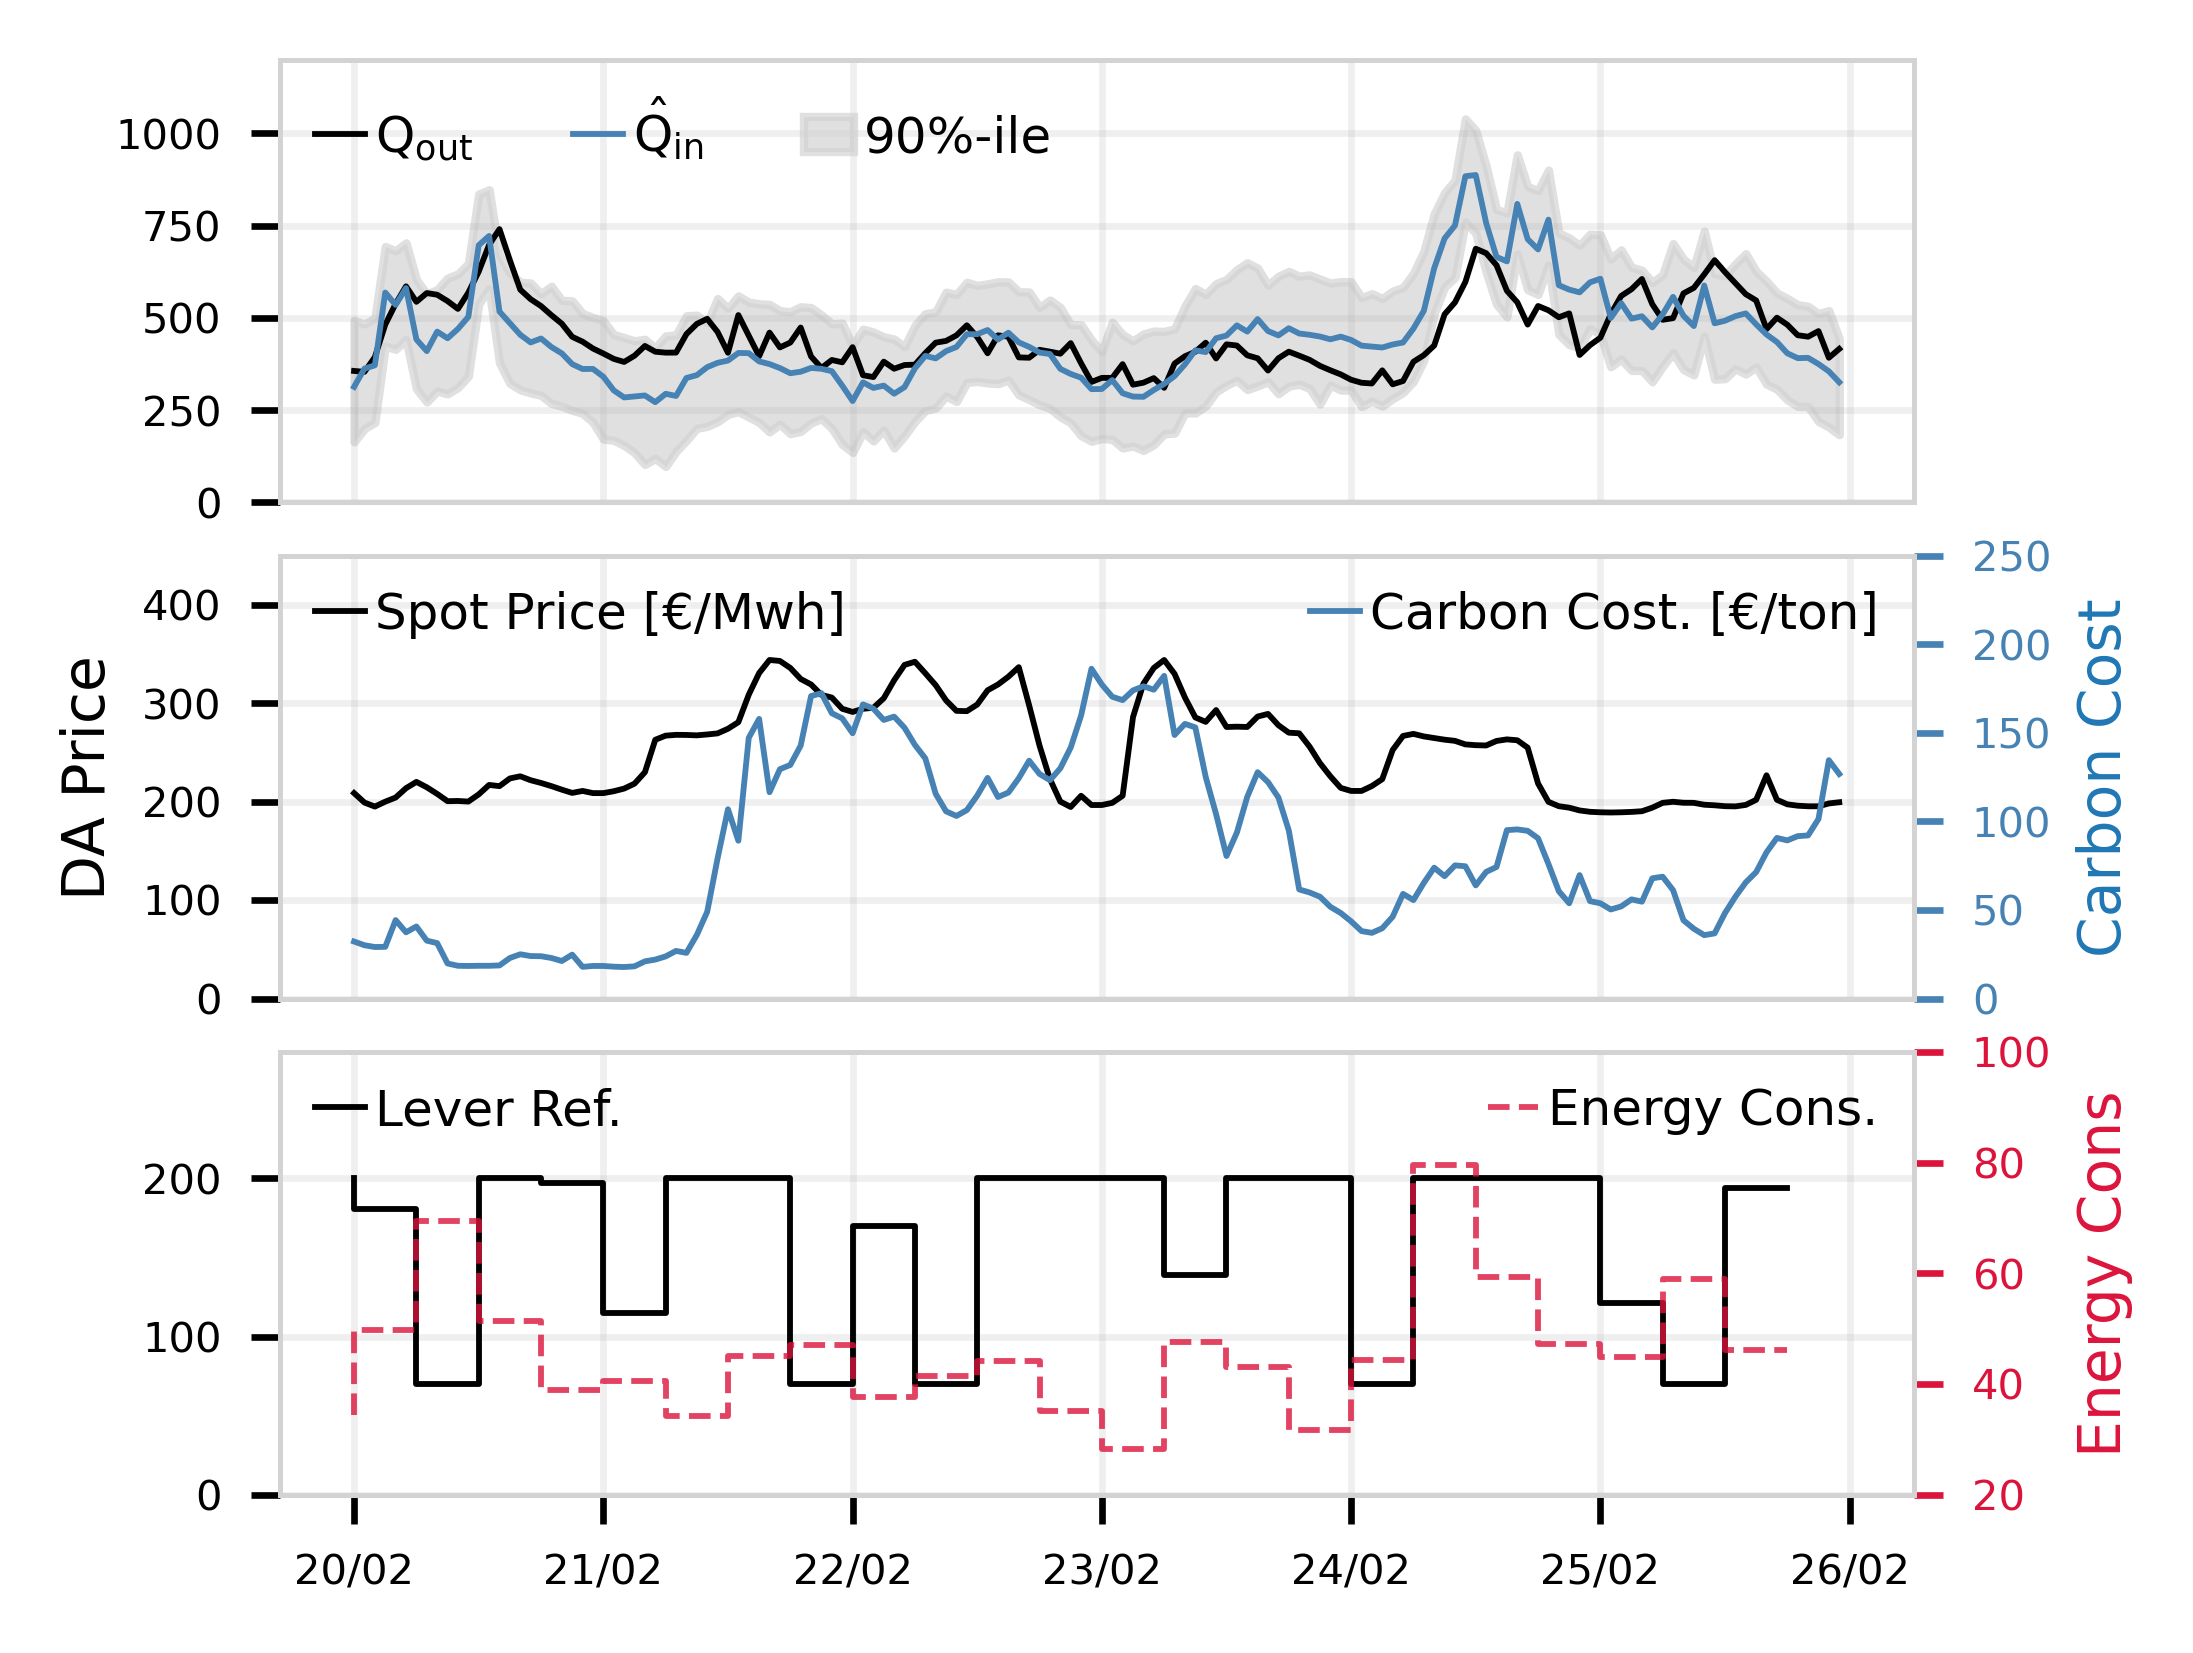

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import warnings
import polars as pl 
import matplotlib.pyplot as plt 
import scienceplots
from matplotlib.ticker import AutoMinorLocator

warnings.filterwarnings('ignore', module='matplotlib')
plt.style.use('ieee')

#===============================#
#         GLOBAL STYLE          #
#===============================#
FONT_SIZE_LABEL    = 7
FONT_SIZE_TITLE    = 7
FONT_SIZE_TICKS    = 5
FONT_SIZE_LEGEND   = 6
AXIS_LABEL_WEIGHT  = 'normal'
LINEWIDTH          = 0.7
LABELPAD           = 3
MARKERSIZE         = 2


LEGEND_PARAMS = dict(
    fontsize=FONT_SIZE_LEGEND,  # can reduce this too!
    frameon=False, fancybox=True,
    edgecolor='white', framealpha=1,
    handlelength=1,          # or even 0.8
    handletextpad=0.2,
    borderpad=0.5,
    labelspacing=0.3,
    borderaxespad=0.2
)

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': 'DejaVu Sans',  # Use 'Helvetica' if installed
    'font.size': 16,
    'pdf.fonttype': 42,
    'axes.labelsize': FONT_SIZE_LABEL,
    'axes.labelweight': AXIS_LABEL_WEIGHT,
    'axes.titlesize': FONT_SIZE_TITLE,
    'xtick.labelsize': FONT_SIZE_TICKS,
    'ytick.labelsize': FONT_SIZE_TICKS,
    'legend.fontsize': FONT_SIZE_LEGEND,
    'lines.linewidth': 1,
    'lines.markersize': MARKERSIZE,
})

#=========================#
#      PLOTTING LAYOUT    #
#=========================#
fig, axs = plt.subplots(
    3, 1,
    figsize=(3.5, 2.6),
    gridspec_kw=dict(height_ratios=[1, 1, 1]),
    sharex=True,   # <-- share the time axis
    # sharey=True, # <-- Uncomment if you want all left y-axes to be identical scales
)
step = 6

#----- Top panel -----#
ax1 = axs[0]
ax1.plot(results_df['time_utc'], results_df['qout'], label = r'$\text{Q}_{\text{out}}$', lw=LINEWIDTH, color="k",  linestyle="-")
ax1.plot(results_df['time_utc'], results_df['qin_q50'], label = r'$\hat{\text{Q}}_{\text{in}}$', lw=LINEWIDTH, color= "steelblue", linestyle="-")
ax1.fill_between(results_df['time_utc'], results_df["qin_q10"],results_df["qin_q90"],color="lightgrey",alpha=0.7,label="90%-ile",zorder=0)
ax1.legend(loc="upper left", ncols=3, **LEGEND_PARAMS)
#ax1.set_ylabel(r'Flow ($\mathrm{m}^3/\mathrm{h}$)', labelpad=LABELPAD, fontweight=AXIS_LABEL_WEIGHT)
ax1.grid(True, zorder=0, alpha=0.3)
ax1.set_ylim(0,1200)
ax1.xaxis.set_major_formatter(DateFormatter('%d/%m'))
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.setp(ax1.xaxis.get_majorticklabels(), visible=True)

#----- Second panel (middle) -----#
ax2 = axs[1]
ax2b = ax2.twinx()  # Explicitly add the twin for symmetry and future plotting
ax2.plot(results_df['time_utc'], results_df["da_price"]*1000,  lw=LINEWIDTH, color="k",  linestyle="-", label = r'Spot Price [€/Mwh]')
ax2b.plot(results_df['time_utc'], results_df["co2_progn"]*1000, lw=LINEWIDTH, color= "steelblue", linestyle="-", label=r'Carbon Cost. [€/ton]')
ax2.set_ylabel('DA Price', labelpad=LABELPAD, fontweight=AXIS_LABEL_WEIGHT)
ax2b.set_ylabel('Carbon Cost', labelpad=LABELPAD, fontweight=AXIS_LABEL_WEIGHT, color='tab:blue')
ax2b.tick_params(axis='y', colors='steelblue')
ax2.legend(loc="upper left", ncols=1, **LEGEND_PARAMS)
ax2b.legend(loc="upper right", ncols=1, **LEGEND_PARAMS)
ax2.grid(axis='y', alpha=0.3)
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax2.set_ylim(0,450)
ax2b.set_ylim(0,250)
#----- Third panel (bottom) -----#
ax3 = axs[2]
ax3b = ax3.twinx()
ax3.step(results_df["time_utc"][::step], results_df["height_ref"][::step], lw=LINEWIDTH, color="black",  linestyle="-", label="Lever Ref.")
ax3b.step(results_df["time_utc"][::step], results_df["energy_ref"][::step],  lw=LINEWIDTH, color= "crimson", linestyle="--", alpha=0.8, label="Energy Cons.")
#ax3.set_ylabel('Tank', labelpad=LABELPAD, fontweight=AXIS_LABEL_WEIGHT)
ax3b.set_ylabel('Energy Cons', labelpad=LABELPAD, fontweight=AXIS_LABEL_WEIGHT, color="crimson")
ax3b.tick_params(axis='y', colors='crimson')
ax3.legend(loc="upper left", ncols=1, **LEGEND_PARAMS)
ax3b.legend(loc="upper right", ncols=1, **LEGEND_PARAMS)
ax3.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
ax3b.tick_params(axis='y', labelsize=FONT_SIZE_TICKS, color="crimson")
ax3.set_ylim(0,280)
ax3b.set_ylim(20,100)



#----- Style spines -----#
for ax in [ax1, ax2, ax2b, ax3, ax3b]:
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_linewidth(0.6)
        spine.set_color('lightgrey')

for ax in [ax1, ax2, ax3]:
    for spine in ax.spines.values():
        ax.grid(True, which='major', alpha=0.2)
        ax.grid(True, which='minor', alpha=0.2)
        ax.yaxis.set_minor_locator(AutoMinorLocator(1))
        ax.xaxis.set_minor_locator(AutoMinorLocator(1))

plt.tight_layout(pad=0.1)
plt.savefig('upper_mpc_actuation.pdf', format='pdf', dpi=600, bbox_inches='tight')
plt.show()